In [3]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cat = Table.read('CUT_CLAUDS_HSC_VISTA_Ks23.3_PHYSPARAM_TM.fits')
cat_gal = cat[cat['CLASS'] == 0]
cat_gal = cat_gal[cat_gal['MASS_BEST']>7]

## Total Satellite Mass Evolution

In [ ]:
total_mass_sat_log = open('total_mass_sat')
z = []
mass_sat= []
mass_sat_sf = []
mass_sat_q = []
std_mass_sat = []
std_mass_sat_sf = []
std_mass_sat_q = []

for line in total_mass_sat_log.readlines():
    z.append(eval(line.split()[0]))
    mass_sat.append(eval(line.split()[1]))
    mass_sat_sf.append(eval(line.split()[2]))
    mass_sat_q.append(eval(line.split()[3]))
    std_mass_sat.append(eval(line.split()[4]))
    std_mass_sat_sf.append(eval(line.split()[5]))
    std_mass_sat_q.append(eval(line.split()[6]))

z = np.array(z)
mass_sat = np.array(mass_sat)
mass_sat_sf = np.array(mass_sat_sf)
mass_sat_q = np.array(mass_sat_q)
std_mass_sat = np.array(std_mass_sat)
std_mass_sat_sf = np.array(std_mass_sat_sf)
std_mass_sat_q = np.array(std_mass_sat_q)

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=16), plt.rc('ytick', labelsize=16)

plt.errorbar(z,mass_sat, yerr=std_mass_sat, fmt='.-k',markersize=16, capsize=3, elinewidth=1,label='total')
plt.errorbar(z,mass_sat_sf, yerr=std_mass_sat_sf, fmt='.-b',markersize=16, capsize=3, elinewidth=1,label='star forming')
plt.errorbar(z,mass_sat_q, yerr=std_mass_sat_q, fmt='.-r',markersize=16, capsize=3, elinewidth=1, label='quiescent')

plt.xlabel('redshift z', fontsize=18)
plt.ylabel(r'total sat mass ($10^8 M_\odot$)', fontsize=18)
plt.tick_params(axis='both',direction='in',which='major',length=8,top='on',right='on')
plt.tick_params(axis='both',direction='in',which='minor',length=4,top='on',right='on')
plt.legend(fontsize=20,frameon=False)
plt.savefig('total_sat_mass_z.png')
plt.show()

In [ ]:
cat_high_z = cat_gal[cat_gal['ZPHOT']>5]
np.min(abs(cat_high_z['MASS_BEST']))

## Uniformity of Blank Pointings

In [ ]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
from random import random
import astropy.units as u
from astropy.cosmology import Planck15, WMAP9

In [ ]:
z = 1.1
dis = WMAP9.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

counts_var = []
for i in range(0,1000):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 1.5/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        mass_neighbors_rand = cat_neighbors_rand['MASS_BEST']
        count_gal_rand, edges_rand = np.histogram(10**(mass_neighbors_rand - 11.3) , np.arange(0,1.01,0.1))
        
        counts_var.append(count_gal_rand)

counts_var_all = np.vstack(counts_var)
std = np.std(counts_var_all, axis=0)
mean = np.mean(counts_var_all, axis=0)

fig = plt.figure(figsize=(9,6))
plt.errorbar(edges_rand[0:-1]+0.05,mean,yerr=std, fmt='.k', markersize=16, capsize=3, elinewidth=1)
# plt.ylim([0,15])
plt.xlabel(r'$M/10^{11.3}M_\odot$', fontsize=15)
plt.savefig('background.png')
plt.show()

In [ ]:
from astropy.stats import bootstrap

In [ ]:
z = 1.1
dis = Planck15.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

total_mass_neighbrs_rand = []
for i in range(0,200):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 3.0/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        if np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8))==0: continue
        total_mass_neighbrs_rand.append(np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8)))

total_mass_neighbrs_rand = np.array(total_mass_neighbrs_rand)
print(np.mean(total_mass_neighbrs_rand), np.std(total_mass_neighbrs_rand))
bootresult = bootstrap(total_mass_neighbrs_rand,100,bootfunc=np.mean)
plt.hist(bootresult)
print(np.mean(bootresult), np.std(bootresult))

fig = plt.figure(figsize=(9,6))
plt.hist(total_mass_neighbrs_rand)
plt.xlabel(r'Total Mass in the field $(10^8 M_\odot)$',fontsize=16)
plt.savefig('background_mass.png')
plt.show()

## massive gal distribution (completeness plot)

In [ ]:
# mass completeness limit at different redshift bins

m_min_list = []
for z in np.arange(1,30)/10.:
    cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_all_z_slice.sort('Ks')
    cat_all_z_slice = cat_all_z_slice[0:int(0.2*len(cat_all_z_slice))]
    
    m_min_gals = cat_all_z_slice['MASS_BEST']+0.4*(cat_all_z_slice['Ks']-23.3)
    m_min_gals.sort()
    m_min_z = m_min_gals[int(0.95*len(m_min_gals))]
    
    m_min_list.append(m_min_z)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(cat_gal[cat_gal['SSFR_BEST']>-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']>-11]['MASS_BEST'],'.b',markersize=3,alpha=0.5,label='SF')
plt.plot(cat_gal[cat_gal['SSFR_BEST']<-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']<-11]['MASS_BEST'],'.r',markersize=3,alpha=0.5,label='Q')
plt.plot(np.arange(1,30)/10., m_min_list,'-ok',markersize=10,markerfacecolor="None")
plt.ylim([6,13])
plt.xlim([0,6.1])
plt.xlabel('redshift z', fontsize=15)
plt.ylabel(r'log(M/M$_\odot$)', fontsize=15)
plt.grid(True)
plt.legend(fontsize=15,loc='lower right')
plt.savefig('completeness.png')
plt.show()

## angular separation

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [ ]:
def spherical_separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    ra1 = ra1/180.*np.pi
    ra2 = ra2/180.*np.pi
    dec1 = dec1/180.*np.pi
    dec2 = dec2/180.*np.pi
    return np.arccos(np.sin(dec1)*np.sin(dec2)+np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2))/np.pi*180

def separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    return np.sqrt((ra1-ra2)**2+(dec1-dec2)**2)

In [ ]:
ra1 = cat_gal['RA']
dec1 = cat_gal['DEC']
ra2 = cat_gal[122]['RA']
dec2 = cat_gal[122]['DEC']
# print(ra1, dec1, ra2, dec2)
# print(spherical_separation(ra1, dec1, ra2, dec2))
# print(separation(ra1, dec1, ra2, dec2))

c1 = SkyCoord(ra1*u.deg,dec1*u.deg)
c2 = SkyCoord(ra2*u.deg,dec2*u.deg)

## physical search radius

In [6]:
from astropy.cosmology import Planck15, WMAP9

In [ ]:
z=0.3
dis = WMAP9.angular_diameter_distance(z).value
print(dis)
0.5/dis/np.pi*180

## Volumne Density Matching
for massive central gals

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap

m_median = np.array([])
m_16 = np.array([])
m_84 = np.array([])
m_low = np.array([])
m_total = np.array([])
m_mean = np.array([])
m_mean_error = np.array([])
gal_sf = []  # SF galaxy number density
gal_q = []  # Q galaxy number density

for z in np.arange(0.3, 2.0, 0.1):
    dis_l = WMAP9.comoving_distance(z-0.1).value
    dis_h = WMAP9.comoving_distance(z+0.1).value
    
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    density = 0.00003 # Mpc^-3
    num = int(density*survey_v)  # surface densisty propto dis**2
    
    cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_gal_z_slice.sort('MASS_BEST')
    cat_gal_z_slice.reverse()
    cat_massive_gal_z = cat_gal_z_slice[:num]
    gal_sf.append(len(cat_massive_gal_z[cat_massive_gal_z['SSFR_BEST']>-11])/survey_v)  # number density of sf gals in this bin
    gal_q.append(len(cat_massive_gal_z[cat_massive_gal_z['SSFR_BEST']<-11])/survey_v)  # number density of q gals in this bin
    
    for gal in cat_massive_gal_z:
        coord_gal_z_slice = SkyCoord(cat_gal_z_slice['RA'] * u.deg, cat_gal_z_slice['DEC'] * u.deg)
        coord_gal = SkyCoord(gal['RA'] * u.deg, gal['DEC'] * u.deg)
        cat_neighbors = cat_gal_z_slice[coord_gal_z_slice.separation(coord_gal).degree < 0.5/dis/np.pi*180]
        cat_neighbors = cat_neighbors[cat_neighbors['ID'] != gal['ID']]  # exclude central gal itself
        
        if len(cat_neighbors) == 0:  # exlucde central gals which has no companion
            cat_massive_gal_z = cat_massive_gal_z[cat_massive_gal_z['ID'] != gal['ID']]
            continue
        if gal['MASS_BEST'] < max(cat_neighbors['MASS_BEST']):  # exclude central gals which has larger mass companion
            cat_massive_gal_z = cat_massive_gal_z[cat_massive_gal_z['ID'] != gal['ID']]
    
    print(z, cat_gal_z_slice[num]['MASS_BEST'], num)
    m_median = np.append(m_median,10**(np.median(cat_massive_gal_z['MASS_BEST'])-10))
    m_16 = np.append(m_16,10**(np.percentile(cat_massive_gal_z['MASS_BEST'],16)-10))
    m_84 = np.append(m_84,10**(np.percentile(cat_massive_gal_z['MASS_BEST'],84)-10))
    m_low = np.append(m_low, 10**(cat_massive_gal_z['MASS_BEST'][-1]-10))
    m_total = np.append(m_total, sum( 10**(cat_massive_gal_z['MASS_BEST'] - 10) ))
    m_mean = np.append(m_mean, m_total[-1]/len(cat_massive_gal_z))
    
    bootsresult_m_mean = bootstrap(10**(cat_massive_gal_z['MASS_BEST']-10), 20, bootfunc=np.mean)
    m_mean_error = np.append(m_mean_error, np.std(bootsresult_m_mean))
print(m_mean)
print(m_mean_error)

In [ ]:
z=0.4
fig = plt.figure(figsize=(9,9))
dis_l = WMAP9.comoving_distance(z-0.1).value
dis_h = WMAP9.comoving_distance(z+0.1).value
    
total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
survey_v = total_v * 4 / 41253.05  #Mpc^3
cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
cat_gal_z_slice.sort('MASS_BEST')
cat_gal_z_slice.reverse()
    
density_list = []
for mass in np.arange(10,12,0.1):
    density = len(cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>mass])/survey_v
    density_list.append(density)
plt.plot(np.arange(10,12,0.1),density_list,label=str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1)))

for z in np.arange(0.75, 2.5, 0.5):
    dis_l = WMAP9.comoving_distance(z-0.25).value
    dis_h = WMAP9.comoving_distance(z+0.25).value
    
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.25]
    cat_gal_z_slice.sort('MASS_BEST')
    cat_gal_z_slice.reverse()
    
    density_list = []
    for mass in np.arange(10,12,0.1):
        density = len(cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>mass])/survey_v
        density_list.append(density)
    
    plt.plot(np.arange(10,12,0.1),density_list,label=str(round(z-0.25,1))+'<z<'+str(round(z+0.25,1)))

plt.axhline(y=5e-6,linestyle='--',color='k')
plt.yscale('log')
plt.ylim([1e-6,1e-2])
plt.xlim([10,11.9])
plt.xlabel(r'log Mass M_$\odot$',fontsize=14)
plt.ylabel(r'Cumulative Number Density [kpc$^{-3}$]',fontsize=14)

plt.legend(fontsize=14,frameon=False)
plt.savefig('cumulative_density.png')
plt.show()
plt.close()

## Number density evolution SF&Q

In [ ]:
np.set_printoptions(precision=1)
z_list = np.arange(3,20)/10.
ind = z_list   # the x locations for the groups
width = 0.06      # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(12,10))
p1 = plt.bar(ind, np.array(gal_sf)*1e5, width,color='b')
p2 = plt.bar(ind, np.array(gal_q)*1e5, width,bottom=np.array(gal_sf)*1e5,color='r')

plt.ylabel('Number Density [1e-5 Mpc-3]',fontsize=16)
plt.xlabel('z',fontsize=16)
plt.xticks(ind, np.arange(3,20)/10.)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('SF', 'Q'),fontsize=16,loc='lower right')
plt.savefig('number_density_sfq.png')
plt.show()

## cumulative massive gals number counts

In [ ]:
fig = plt.figure(figsize=(9,9))

massive_gal_counts_112 = []
massive_gal_counts_113 = []
massive_gal_counts_vs = []
for z in np.arange(0.3, 2.0, 0.2):
    
    # constant mass selection
    cat_gal_z_slice = cat_gal[cat_gal['ZPHOT']>0.2]
    cat_gal_z_slice = cat_gal_z_slice[cat_gal_z_slice['ZPHOT']<z]
    cat_gal_massive_z = cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>11.3]
    massive_gal_counts_113.append(len(cat_gal_massive_z))
    cat_gal_massive_z = cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>11.2]
    massive_gal_counts_112.append(len(cat_gal_massive_z))
    
    # constant volume density selection
    dis_l = WMAP9.comoving_distance(z-0.1).value
    dis_h = WMAP9.comoving_distance(z+0.1).value
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    density = 0.00003 # Mpc^-3
    num = int(density*survey_v)  # surface densisty propto dis**2
    
    cat_gal_z_slice_vs = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_gal_z_slice_vs.sort('MASS_BEST')
    cat_gal_z_slice_vs.reverse()
    cat_massive_gal_z_vs = cat_gal_z_slice_vs[:num]
    if z>0.31:
        massive_gal_counts_vs.append(massive_gal_counts_vs[-1]+len(cat_massive_gal_z_vs)) # vs = volume selected
    else:
        massive_gal_counts_vs.append(len(cat_massive_gal_z_vs))

plt.plot(np.arange(0.3, 2.0, 0.2),massive_gal_counts_112,'.-',label='ms at M=11.2')
plt.plot(np.arange(0.3, 2.0, 0.2),massive_gal_counts_113,'.-',label='ms at M=11.3')
plt.plot(np.arange(0.3, 2.0, 0.2)+0.1,massive_gal_counts_vs,'.-',label='vs at n=3e-5')
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('cumulative counts of massive gals', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('nz.png')
plt.show()

## Pair Fraction
galaxies with at least one companinon more massive than its 1/10 mass

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.show()

### Mass Growth Plot

In [ ]:
mass_growth_mean_k = open('mass_growth_k').readlines()
mass_growth_mean_j = open('mass_growth_j').readlines()

In [ ]:
z_list = np.arange(0.3, 2.0, 0.1)

fig = plt.figure(figsize=(10,8))
plt.plot(z_list,m_median,'.-r',markersize=10,label='Median')
plt.plot(z_list,m_16,'-r',alpha=0.2)
plt.plot(z_list,m_84,'-r',alpha=0.2)
plt.plot(z_list,m_low,'.-b',markersize=10,label='Lowest')
plt.errorbar(z_list,m_mean,yerr=m_mean_error,fmt='.-g', markersize=10,ecolor='y', label='Mean')

for i in range(1,len(z_list)):
    mass_growth = eval(mass_growth_mean_k[i])
    original_mass = m_mean[i]
    merged_mass = original_mass + mass_growth
    plt.plot([z_list[i-1],z_list[i]],[merged_mass,original_mass],'--g',alpha=0.5)
    plt.plot(z_list[i-1],merged_mass,'*g',markersize=9,alpha=0.5,label='K08' if 'K08' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    
    mass_growth = eval(mass_growth_mean_j[i])
    original_mass = m_mean[i]
    merged_mass = original_mass + mass_growth
    plt.plot([z_list[i-1],z_list[i]],[merged_mass,original_mass],'-.g',alpha=0.5)
    plt.plot(z_list[i-1],merged_mass,'sg',markersize=6,alpha=0.5,label='J08' if 'J08' \
            not in plt.gca().get_legend_handles_labels()[1] else '')

plt.xlabel('Redshift',fontsize=15)
plt.ylabel(r'(M / 10$^{10}$ M$_\odot$)',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('mass=_growth.png')
plt.show()

## Test Plot

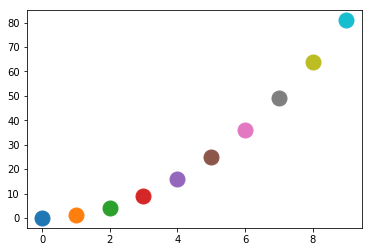

In [4]:
for i in range(10):
    plt.plot(i,i**2,'o',markersize=15)
    
plt.show()

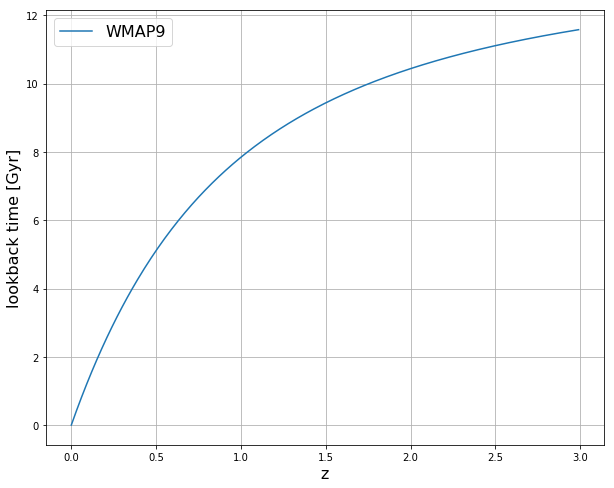

In [9]:
t = []
for z in np.arange(0,3,0.01):
    t.append(WMAP9.lookback_time(z).value)

fig = plt.figure(figsize=(10,8))    
plt.plot(np.arange(0,3,0.01),t, label='WMAP9')
plt.xlabel('z',fontsize=16)
plt.ylabel('lookback time [Gyr]',fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.savefig('figures/time_z.png',dpi=150)
plt.show()

## Companion Radial Distribution

In [ ]:
mode = 'count'
radial_total = np.load('count.npy')
radial_total_err = np.load('count_err.npy')
radial_sf = np.load('count_sf.npy')
radial_q = np.load('count_q.npy')
radial_q_err = np.load('count_q_err.npy')
radial_sf_err = np.load('count_sf_err.npy')
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_total, fmt='.-k', yerr=radial_total_err,label='total')
plt.errorbar(bin_edges[:-1], radial_sf, fmt='.-b', yerr=radial_sf_err,label='sf')
plt.errorbar(bin_edges[:-1], radial_q, fmt='.-r', yerr=radial_q_err,label='q')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
if mode == 'mass':
    plt.ylabel(r'M/10$^{10}$M$_\odot$ kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
    plt.savefig('radial_mass_sfq.png')
else:
    plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
    plt.savefig('radial_count_sfq.png')

plt.show()

In [ ]:
# low/high mass cut at m = 10.1

mode = 'count'
radial_total = np.load('count.npy')
radial_total_err = np.load('count_err.npy')
radial_l = np.load('count_low.npy')
radial_l_err = np.load('count_low_err.npy')
radial_h_err = np.load('count_high_err.npy')
radial_h = np.load('count_high.npy')          
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_total, fmt='.-k', yerr=radial_total_err,label='total')
plt.errorbar(bin_edges[:-1], radial_l, fmt='.-g', yerr=radial_l_err,label='low mass')
plt.errorbar(bin_edges[:-1], radial_h, fmt='.-m', yerr=radial_h_err,label='high mass')
plt.plot(np.linspace(10,700,num=100),nfw2(np.linspace(10,700,num=100),260, 1.8e-5),'--',alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
if mode == 'mass':
    plt.ylabel(r'M/10$^{10}$M$_\odot$ kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
    plt.savefig('radial_mass_mass.png')
else:
    plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
    plt.savefig('radial_count_mass.png')
plt.show()

## Mass Density Radial Distribution

In [ ]:
radial_mass = np.load('mass0.6.npy') #882
radial_mass_err = np.load('mass0.6_err.npy')   
radial_mass2 = np.load('mass0.6_mass_0.1.npy') #611
radial_mass2_err = np.load('mass0.6_mass_0.1_err.npy')   
radial_mass3 = np.load('mass0.06.npy') #339
radial_mass3_err = np.load('mass0.06_err.npy')   
radial_mass4 = np.load('mass0.04.npy') #223
radial_mass4_err = np.load('mass0.04_err.npy')   
bin_edges = np.load('bin_edges.npy')

popt,pcov = curve_fit(nfw2, bin_edges[2:-1], radial_mass[2:],p0=[160,5e-5],bounds=[(0,0),(500,5e-3)])

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_mass, fmt='o-k', yerr=radial_mass_err,label='bin size 0.15')
plt.errorbar(bin_edges[:-1], radial_mass2, fmt='o-b', yerr=radial_mass2_err,label='bin size 0.1')
plt.errorbar(bin_edges[:-1], radial_mass3, fmt='o-m', yerr=radial_mass3_err,label='bin size 0.06')
plt.errorbar(bin_edges[:-1], radial_mass4, fmt='o-g', yerr=radial_mass4_err,label='bin size 0.04')
plt.plot(np.linspace(10,700,num=100),nfw2(np.linspace(10,500,num=100),popt[0], popt[1]),'--k',alpha=0.7,label='NFW fit')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'M/10$^{10}$M$_\odot$ kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_mass_binsize.png')

plt.show()

In [ ]:
mode = 'mass'
radial_mass = np.load('mass0.3.npy') #882
radial_mass_err = np.load('mass0.3_err.npy')   
radial_mass2 = np.load('mass0.6.npy') #611
radial_mass2_err = np.load('mass0.6_err.npy')
radial_mass3 = np.load('mass1.2.npy') #611
radial_mass3_err = np.load('mass1.2_err.npy')  
radial_mass4 = np.load('mass1.5.npy') #611
radial_mass4_err = np.load('mass1.5_err.npy')  
bin_edges = np.load('bin_edges.npy')

popt,pcov = curve_fit(nfw2, bin_edges[1:-1], radial_mass2[1:],sigma=radial_mass2_err[1:], 
                      p0=[200,4e-5],bounds=[(0,0),(500,5e-3)], method='trf')
print(popt)

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_mass, fmt='.-k', yerr=radial_mass_err,label='0.3')
plt.errorbar(bin_edges[:-1], radial_mass2, fmt='.-b', yerr=radial_mass2_err,label='0.6')
plt.errorbar(bin_edges[:-1], radial_mass3, fmt='.-m', yerr=radial_mass3_err,label='1.2')
plt.errorbar(bin_edges[:-1], radial_mass4, fmt='.-g', yerr=radial_mass4_err,label='1.5')
plt.plot(np.linspace(10,700,num=100),nfw2(np.linspace(10,500,num=100),popt[0],popt[1]),'--g',alpha=0.7,label='NFW fit')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'M/10$^{10}$M$_\odot$ kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_mass_redshift.png')

plt.show()

## varying some selection parameters

In [ ]:
radial_1 = np.load('count0.3.npy')  
radial_1_err = np.load('count0.3_err.npy')
radial_2 = np.load('count0.6.npy')  
radial_2_err = np.load('count0.6_err.npy')
radial_3 = np.load('count1.2.npy')  
radial_3_err = np.load('count1.2_err.npy')
radial_4 = np.load('count1.5.npy')  
radial_4_err = np.load('count1.5_err.npy')
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_1, fmt='.-k', yerr=radial_1_err,label='z=0.3')
plt.errorbar(bin_edges[:-1], radial_2, fmt='.-g', yerr=radial_2_err,label='z=0.6')
plt.errorbar(bin_edges[:-1], radial_3, fmt='.-m', yerr=radial_3_err,label='z=1.2')
plt.errorbar(bin_edges[:-1], radial_4, fmt='.-r', yerr=radial_4_err,label='z=1.5')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_count_redshift.png')
plt.show()

In [ ]:
radial_1 = np.load('count_bin0.1.npy')  
radial_1_err = np.load('count_bin0.1_err.npy')
radial_2 = np.load('count0.6.npy')  
radial_2_err = np.load('count0.6_err.npy')
radial_3 = np.load('count_bin0.18.npy')  
radial_3_err = np.load('count_bin0.18_err.npy')
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_1, fmt='.-k', yerr=radial_1_err,label='11.0')
plt.errorbar(bin_edges[:-1], radial_2, fmt='.-g', yerr=radial_2_err,label='11.05')
plt.errorbar(bin_edges[:-1], radial_3, fmt='.-m', yerr=radial_3_err,label='11.1')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_count_masscut.png')
plt.show()

In [ ]:
radial_1 = np.load('count_cut11.npy')  
radial_1_err = np.load('count_cut11_err.npy')
radial_2 = np.load('count_cut11.1.npy')  
radial_2_err = np.load('count_cut11.1_err.npy')
radial_3 = np.load('count_cut11.2.npy')  
radial_3_err = np.load('count_cut11.2_err.npy')
radial_4 = np.load('count_cut11.3.npy')  
radial_4_err = np.load('count_cut11.3_err.npy')
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_1, fmt='.-k', yerr=radial_1_err,label='11.0')
plt.errorbar(bin_edges[:-1], radial_2, fmt='.-g', yerr=radial_2_err,label='11.1')
plt.errorbar(bin_edges[:-1], radial_3, fmt='.-m', yerr=radial_3_err,label='11.2') #400
plt.errorbar(bin_edges[:-1], radial_4, fmt='.-r', yerr=radial_4_err,label='11.3') #213
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_count_masscut2.png')
plt.show()

In [ ]:
radial_1 = np.load('count_bin0.06.npy')  
radial_1_err = np.load('count_bin0.06_err.npy')
radial_2 = np.load('count_bin0.1.npy')  
radial_2_err = np.load('count_bin0.1_err.npy')
radial_3 = np.load('count0.6.npy')  
radial_3_err = np.load('count0.6_err.npy')
radial_4 = np.load('count_bin0.2.npy')  
radial_4_err = np.load('countbin0.2_err.npy')
bin_edges = np.load('bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1], radial_1, fmt='.-', yerr=radial_1_err,label='0.06')
plt.errorbar(bin_edges[:-1], radial_2, fmt='.-', yerr=radial_2_err,label='0.1')
plt.errorbar(bin_edges[:-1], radial_3, fmt='.-', yerr=radial_3_err,label='0.15')
plt.errorbar(bin_edges[:-1], radial_4, fmt='.-', yerr=radial_4_err,label='0.2')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('radial_count_binsize.png')
plt.show()

In [ ]:
import seaborn as sns
sns.set_palette("husl")

## NFW fit

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def nfw(r,rs,n):
    x = r / float(rs)
    if x<1:
        return n*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x))))
    elif x ==1:
        return n*1./3
    else:
        return n*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))

In [ ]:
def nfw2(r, rs, n):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:n*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:n*1./3, 
                      lambda x:n*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

In [ ]:
r = np.linspace(10,700,100)
n = []

for d in r:
    n.append(nfw2(d,160,1e-4))

plt.plot(r,n)
plt.xscale('log')
plt.yscale('log') 
plt.show()

In [ ]:
plt.plot(bin_edges[3:-1], radial_total[3:])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
popt,pcov = curve_fit(nfw2, bin_edges[3:-1], radial_total[3:],p0=[160,5e-5],bounds=[(0,0),(500,5e-3)])
print(popt)

pcov